In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
from numpy.linalg import inv
import requests
from scipy.stats import norm

In [6]:
stock = ["VNM","LTG","AFX","AGM","BLT","VSF","SAF"]
data_stock = pd.DataFrame()
for ii in stock:
    link = 'https://iboard.ssi.com.vn/dchart/api/history?resolution=D&symbol=%s&from=1500853946&to=1650549686' % ii
    # data from 2019-02-25 -> 2021-07-23
    data_raw = requests.get(link)
    dataReader = pd.DataFrame(data_raw.json())
    dataReader['t'] = pd.to_datetime(dataReader['t'], unit='s')
    dataReader['c'] = dataReader['c'].astype('float')
    #data = pd.DataFrame(data,columns = [ii])
    dataReader.to_csv("%s.csv" %ii)

In [34]:
data_stock

,VNM,LTG,AFX,AGM,BLT,VSF,SAF
0,115.80,NaN,NaN,NaN,NaN,NaN,NaN
1,111.59,NaN,NaN,NaN,NaN,NaN,NaN
2,112.82,NaN,NaN,NaN,NaN,NaN,NaN
3,107.77,NaN,NaN,NaN,NaN,NaN,NaN
4,108.00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
235,NaN,NaN,NaN,NaN,NaN,NaN,55.0
236,NaN,NaN,NaN,NaN,NaN,NaN,51.1
237,NaN,NaN,NaN,NaN,NaN,NaN,55.0
238,NaN,NaN,NaN,NaN,NaN,NaN,57.0


In [40]:
# data
FPT = 'https://iboard.ssi.com.vn/dchart/api/history?resolution=D&symbol=VSF&from=1550853946&to=1650549686'
data_raw = requests.get(FPT)
dataReader = pd.DataFrame(data_raw.json())
dataReader['t'] = pd.to_datetime(dataReader['t'], unit='s')
data = np.array(dataReader['c'].astype('float'))

In [41]:
dataReader

,t,o,h,l,c,v,s
0,2019-02-27,8.80,8.80,8.80,8.80,1000,ok
1,2019-02-28,8.00,8.00,8.00,8.00,1000,ok
2,2019-03-01,8.50,9.20,8.50,9.20,800,ok
3,2019-03-04,9.50,9.50,9.50,9.50,100,ok
4,2019-03-06,9.90,10.00,9.90,10.00,500,ok
...,...,...,...,...,...,...,...
197,2021-07-14,6.20,6.20,6.20,6.20,100,ok
198,2021-07-15,6.20,6.20,6.20,6.20,1000,ok
199,2021-07-19,6.20,6.20,6.20,6.20,1500,ok
200,2021-07-20,6.20,6.20,6.20,6.20,800,ok


# Kalman Filter

In [10]:
data = pd.read_csv("sticker_data.csv", sep = ";")

In [11]:
data.head()

,date,f0_
0,15/05/2021,684
1,16/05/2021,604
2,17/05/2021,822
3,18/05/2021,877
4,19/05/2021,840


In [14]:
data = np.array(data['f0_'].astype('float'))

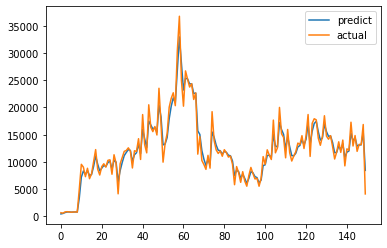

In [18]:
A = np.array([[1]]) 
B = np.array([[0]]) 
C = np.array([[1]]) 
Q = np.array([[1]]) 
R = np.array([[1]])
d = np.array([[0]])
n = A.shape[1]
mu_d = 0
sig_d = 1
#mu_m = data[0]
mu_m = 30
sig_m = 1
u = 0
ii = []
for i in range(0,len(data)):
    # Predict
    mu_d = np.dot(A, np.transpose(mu_m)) + np.dot(B, u)
    sig_d = np.dot(A, sig_m).dot(np.transpose(A)) + Q
    # Update
    T = np.dot(C, sig_d).dot(np.transpose(C)) + R
    if len(T.shape) >1:
        T = inv(T)
    else:
        T = inv(np.expand_dims(T,axis=1))
    K = sig_d.dot(np.transpose(C)).dot(T)
    mu_m = mu_d + K.dot(data[i] - (np.dot(C, mu_d) + d))
    sig_m = (np.identity(n) - K.dot(C)).dot(sig_d)
    ii.append(mu_m[0])
#plt.figure(figsize=(30,20))
plt.plot(ii,label = 'predict')
plt.plot(data,label = 'actual')
plt.legend()

# Particle Filter

In [16]:
n = 100
t = len(data)
y = data[:t]
x = norm.rvs(loc = 0, scale = 1, size = n).reshape(-1,1)
w = np.repeat(1/n,n).reshape(-1,1)
w[:,-1] = w[:,-1]/w[:,-1].sum()
for stt in range(1,t):
    x_temp = []
    w_temp = []
    for i in range(0,n):
        # Sample
        x_plus = norm.rvs(loc = x[i,-1], scale = 1, size = 1)
        x_temp.append(np.round(x_plus[0],2))
        # Calculate weight
        w_temp.append([norm.pdf(x = y[stt], loc = 1*x[i,-1], scale = 1)])
    w = np.append(w, w_temp, axis = 1)
    x = np.append(x, np.array(x_temp).reshape(-1,1), axis = 1)
    # Resample
    w[:,-1] = w[:,-1]/w[:,-1].sum()
    ind = np.random.choice(np.arange(n),size = n ,p = w[:,-1], replace = True)
    x_new = []
    for i in ind:
        x_new.append(x[i,:])
    x = np.array(x_new)
    
#plt.figure(figsize=(40,20))
plt.plot(x.mean(axis = 0),label = 'predict')
plt.plot(data,label = 'actual')
plt.legend()

/var/folders/w1/tkn00chn405f8dp8bw9mrbnw0000gn/T/ipykernel_19605/1067541244.py:19: RuntimeWarning: invalid value encountered in true_divide
  w[:,-1] = w[:,-1]/w[:,-1].sum()


ValueError: probabilities contain NaN

### In this case, when I test Kalman Filter and Particle Fiter for investigating prediction FPT's price stock. We can see that result of Kalman Filter is better than Particle Filter. 